### Import Needed Libraries

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt

### Geometry Definitions of Hot Water Tank

In [85]:
# Tank dimensions
diameter = 2.25

height = 7.5

tower_overHeight = 2.0

width = 2
length = 4
thickness = 0.125

shape = "rectangular"

total_height = tower_overHeight + 8

# Heating element dimensions
cartridge_diameter = 0.5
cartridge_height = 7
wattage = 1500

d = 0.25*2.54/100 # convert to m
length_pipe = 0.3 # 10cm
Cv = 4.8
rho = 965.31 # density of water kg/m^3 at 90degC
mu = 0.0003142 # viscosity of water at 90degC
xi = 4.08
grav = 9.81
relative_roughness = 0.005

### Thermodynamic Requirements

#### Next the machine will determine the fractions of water to be delivered to the filter at each of the 4 stages of coffee filtering. Please see Blue Bottle tips (https://bluebottlecoffee.com/preparation-guides/pour-over).


In [86]:
pour = [60, 90, 100, 100]
rest = [30, 45, 45, 45]
time = [15, 15, 20, 20]

setting = "double"

# Only if trying for double cup performance
if setting == "double":
    pour = [i * 2 for i in pour]
    rest = [i * 1.5 for i in rest]
    time = [i * 2 for i in rest]


m = np.zeros(len(pour))
m[0] = pour[0]

for i in range(len(m)-1):
    m[i+1] = pour[i+1] - ((wattage * (rest[i]-pour[i]*60/400)) / (4.19 * 75)) # leftover mass
    #print((wattage * rest[i]) / (4.19 * 75))

min_volume = sum(m)
print(pour)

print("Minimum starting water volume:")
print(min_volume)

[120, 180, 200, 200]
Minimum starting water volume:
198.80668257756574


### Compute Usable Internal Volume in Water Tank

In [87]:
if shape == "rectangular": # selects the shape of the tank from the provided user inputs
    volume = (width - 2*thickness) * 2.54 * (length - 2*thickness) * 2.54 * height * 2.54
else:
    volume = math.pi*((diameter*2.54/2)**2)*(height*2.54)

        
cartridge_volume = math.pi*((cartridge_diameter*2.54/2)**2)*(cartridge_height*2.54)

empty_volume = volume - cartridge_volume

upper_volume = volume * (1 - cartridge_height/height)
lower_volume = empty_volume - upper_volume

flowable_volume = lower_volume * (1 - (height - tower_overHeight)/cartridge_height) + upper_volume
unflowable_water = lower_volume * (height - tower_overHeight)/cartridge_height
req_water = min_volume + lower_volume * (height - tower_overHeight)/cartridge_height

print("Total Volume:")
print(empty_volume)

print("Flowable Volume:")
print(flowable_volume)

print("Minimum Required Water:")
print(req_water)

print("Unusable Water:")
print(unflowable_water)


Total Volume:
784.0276588041164
Flowable Volume:
210.25382626159637
Minimum Required Water:
772.5805151200858
Unusable Water:
573.77383254252


### Initialize Variables for Active Pour Time-Step Iteration Sequence

In [88]:
flow_rate = np.zeros(1000)
flow_rate[0] = 1

current_water = np.zeros(1000)
current_water[0] = start_water_volume #defined in millimeters

water_height = np.zeros(1000)

actual_pour = np.zeros(len(m))

Q = np.zeros(1000)
v = np.zeros(1000)
Pp = np.zeros(1000)
Pf = np.zeros(1000)
diff = np.zeros(1000)
friction_losses = np.zeros(1000)

i = 0

### Report Active Design Constraints To User

In [89]:
if req_water < lower_volume:
    start_water_volume = lower_volume
    print("Adjusted water to submerge heating element.")
    print("New starting water volume:")
    print(start_water_volume)
else:
    start_water_volume = req_water
    print("Water volume minimum amount driven by wattage of heater.")
    print("Starting water volume:")
    print(start_water_volume)

additional_volume = empty_volume - start_water_volume
print("Additional Volume Available: ",additional_volume)

added_water = 0
# add water to initial water to increase head height
if added_water > 0:
    start_water_volume = start_water_volume + added_water
    print("New starting water volume (user added):", start_water_volume)
    
if current_water[0] >= lower_volume:
    water_height[0] = cartridge_height + (current_water[0]-lower_volume)/upper_volume * (height - cartridge_height)
else:
    print("Heater not submerged!")
    water_height[0] = (current_water[0]/lower_volume) * cartridge_height
    
print("Starting water height:",water_height[0])

if cartridge_height >= height:
    print("Check cartridge height interference.")
    
if start_water_volume > empty_volume:
    print("Need a bigger tank.")
    
if total_height > 17:
    print("Coffee machine is too tall.")

Water volume minimum amount driven by wattage of heater.
Starting water volume:
772.5805151200858
Additional Volume Available:  11.447143684030607
Starting water height: 7.393554656489155


### Iterate

In [90]:

flow_rate[0] = 1

current_water[0] = start_water_volume #defined in millimeters

for j in range(len(m)):
    
    if j > 0:
        # add water for filling up tank
        current_water[i] = current_water[i] + (pour[j] - m[j])
        # check if the added water would increase volume to something larger than the tank can accomodate
        if current_water[i] > empty_volume:
            # if upper limit of newly heated water is amount is too large decrease to fit in container (could also decrease wattage)
            current_water[i] = empty_volume - 15
            #print("Heater more than powerful - reduced incoming water.")
    
    interval_water = current_water[i]
    
    if current_water[i] >= lower_volume:
        water_height[i] = cartridge_height + (current_water[i]-lower_volume)/upper_volume * (height - cartridge_height)
    else:
        # water does not fully submerge heating element!
        print("Heater not fully submerged!")
        water_height[i] = (current_water[i]/lower_volume) * cartridge_height
        
    head_water_height = tower_overHeight - height + water_height[i]
    
    k = 0 # stand in for actual time - each step is assumed to be 1 sec

    while k < 2*time[j] and interval_water - current_water[i] < pour[j] and head_water_height > 0.01:

        count = 0 # counter to limit the number of times the code will iterate on a single time step
        
        Q = 1 # initial flow rate to pass thru the while logic check
        
        if k > 0:
            Q_prev = flow_rate[i-1] # use previous time step flow rate to be closer to likely converged solution at current timestep
        else:
            Q_prev = 5 # if this is the first time step, use a different Q_prev value to get thru the while logic
            
        head_water_height = tower_overHeight - height + water_height[i] # head water height at a time step will be constant
        head_pressure = rho * grav * head_water_height * 2.54/100/6894.76 # only need to calculate once
                
        unit_add = -0.5
                
        while abs(Q - Q_prev) > 0.01 and count < 200:

            count += 1

            diff[count] = abs(Q - Q_prev)
            
            if diff[count] > diff[count-1]:
                # flip directions and tighten increment
                unit_add = unit_add * -0.5
                
            Q_prev = Q_prev + unit_add

            v = Q_prev/1000000 * 4 / (math.pi * (d**2)) # calculate flow velocity at exit of pipe

            Re = d * v * rho / mu

            a = 1 / (1 + (Re/2720)**9)
            b = 1 / (1 + (Re/(160/relative_roughness))**2)

            f = 1/ ((Re/64)**a * (1.8*np.log10(Re/6.8))**(2*(1-a)*b) * (2.0 * np.log10(3.7/relative_roughness))**(2*(1-a)*(1-b))) # Cheng 2008

            Pp = f * length_pipe/d * rho/2 * v**2

            Pf = xi *  rho/2 * v**2

            friction_losses = (Pf + Pp) * 0.000145038

            if friction_losses < head_pressure:
                Q = Cv * math.sqrt(head_pressure - friction_losses) * (3785.41/60)
                
        flow_rate[i] = Q

        current_water[i+1] = current_water[i] - flow_rate[i]

        if current_water[i] >= lower_volume:
            water_height[i+1] = cartridge_height + (current_water[i]-lower_volume)/upper_volume * (height - cartridge_height)
        else:
            water_height[i+1] = (current_water[i]/lower_volume) * cartridge_height

        i += 1
        k += 1

    actual_pour[j] = interval_water - current_water[i]

    print("Pour volume [ml]",j+1,":",actual_pour[j])
    print("Length of Pour [s]:",k)
    if k > time[j]:
        print("Increase head height for higher water flow.")
    if actual_pour[j] < pour[j]:
        print("Not enough water poured in twice the time!!")
        

Pour volume [ml] 1 : 120.87287709631778
Length of Pour [s]: 11
Pour volume [ml] 2 : 180.0568644813717
Length of Pour [s]: 19
Pour volume [ml] 3 : 198.3631743162697
Length of Pour [s]: 28
Not enough water poured in twice the time!!
Pour volume [ml] 4 : 178.5447729781256
Length of Pour [s]: 26
Not enough water poured in twice the time!!


### Plot Process Data

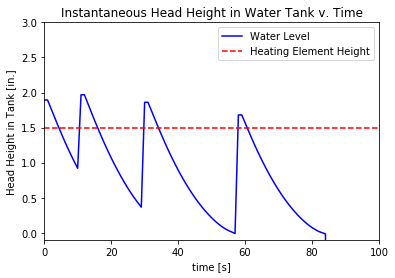

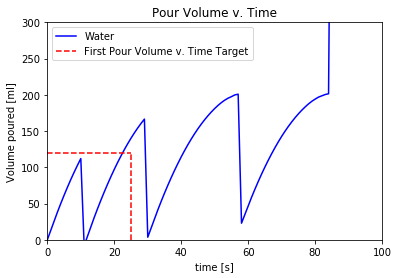

In [91]:
plt.plot(water_height - (height - tower_overHeight),color = 'b')
plt.plot([0, 100],[cartridge_height- (height - tower_overHeight),cartridge_height- (height - tower_overHeight)],'--',color = 'r')
plt.xlim(0, 100)
plt.ylim(-0.1,3)
plt.title('Instantaneous Head Height in Water Tank v. Time')
plt.xlabel('time [s]')
plt.ylabel('Head Height in Tank [in.]')
plt.legend(['Water Level','Heating Element Height'])
plt.show()

plt.plot(current_water[0]-current_water,color = 'b')
plt.plot([0,25],[120,120],'--',color = 'r')
plt.plot([25,25],[0,120],'--',color = 'r')
plt.xlim(0, 100)
plt.ylim(0, 300)
plt.title('Pour Volume v. Time')
plt.ylabel('Volume poured [ml]')
plt.xlabel('time [s]')
plt.legend(['Water','First Pour Volume v. Time Target'])
plt.show()